In [1]:
!pip install nlp
!pip install datasets
import tensorflow as tf
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nlp
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping
from keras.layers import GlobalAvgPool1D
import random

  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.59.0
    Uninstalling tqdm-4.59.0:
      Successfully uninstalled tqdm-4.59.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 4.0.0
    Uninstalling pyarrow-4.0.0:
      Successfully uninstalled pyarrow-4.0.0
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.0.12
    Uninstalling huggingface-hub-0.0.12:
      Successfully uninstalled huggingface-hub-0.0.12


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.39.0 requires numba, which is not installed.
transformers 4.8.2 requires huggingface-hub==0.0.12, but you have huggingface-hub 0.0.17 which is incompatible.
pycaret 2.3.0 requires numpy==1.19.5, but you have numpy 1.21.0 which is incompatible.
pycaret 2.3.0 requires scikit-learn==0.23.2, but you have scikit-learn 0.24.0 which is incompatible.
pycaret 2.3.0 requires scipy<=1.5.4, but you have scipy 1.7.0 which is incompatible.
ernie 0.0.33b0 requires transformers==2.4.1, but you have transformers 4.8.2 which is incompatible.


In [2]:
# Importing the dataset
data = nlp.load_dataset('emotion')

# Converting the train, validation and test datasets into DataFrame format
train = pd.DataFrame(data['train'])
validation = pd.DataFrame(data['validation'])
test = pd.DataFrame(data['test'])

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to C:\Users\russe\.cache\huggingface\datasets\emotion\default\0.0.0\84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [6]:
train.head(15)

,label,text
0,sadness,i didnt feel humiliated
1,sadness,i can go from feeling so hopeless to so damned...
2,anger,im grabbing a minute to post i feel greedy wrong
3,love,i am ever feeling nostalgic about the fireplac...
4,anger,i am feeling grouchy
5,sadness,ive been feeling a little burdened lately wasn...
6,surprise,ive been taking or milligrams or times recomme...
7,fear,i feel as confused about life as a teenager or...
8,joy,i have been with petronas for years i feel tha...
9,love,i feel romantic too


In [7]:
# Check unique labels for data
train['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

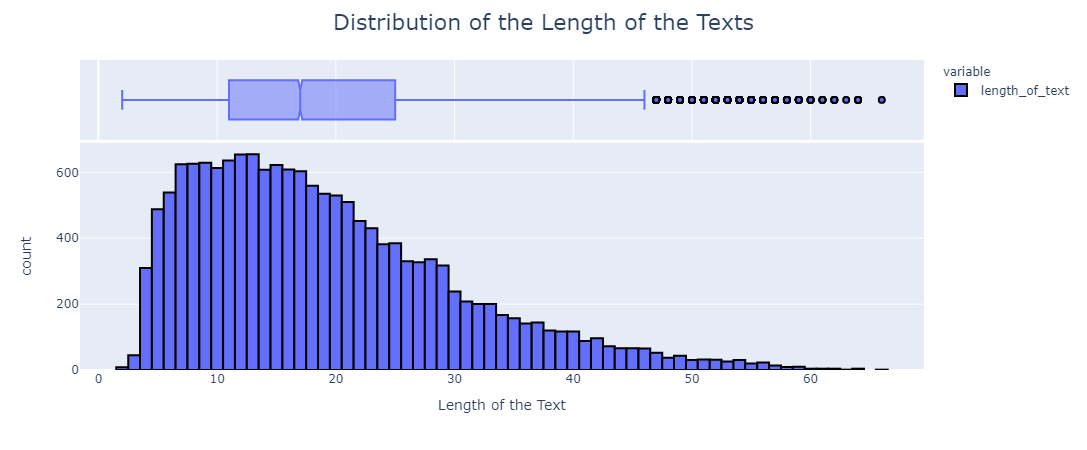

In [9]:
# Distribution of length of texts

train['length_of_text'] = [len(i.split(' ')) for i in train['text']]

fig = px.histogram(train['length_of_text'], marginal='box',
                   labels={"value": "Length of the Text"})

fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Distribution of the Length of the Texts',
                  title_x=0.5, title_font=dict(size=22))
fig.show()

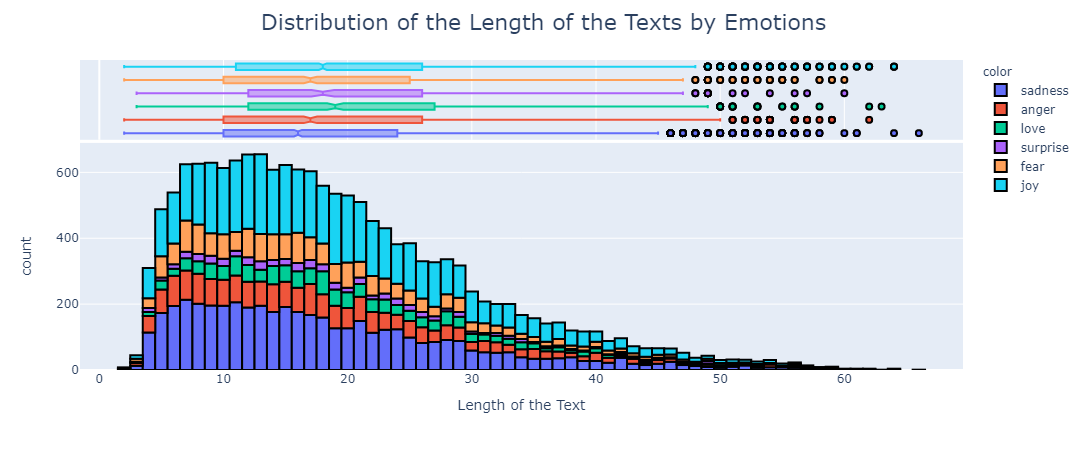

In [10]:
# Distribution of Length of texts by Emotion

fig = px.histogram(train['length_of_text'],
                   marginal='box',
                   labels={"value": "Length of the Text"},
                   color=train['label'])

fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))

fig.update_layout(title_text='Distribution of the Length of the Texts by Emotions',
                  title_x=0.5,
                  title_font=dict(size=22))
fig.show()

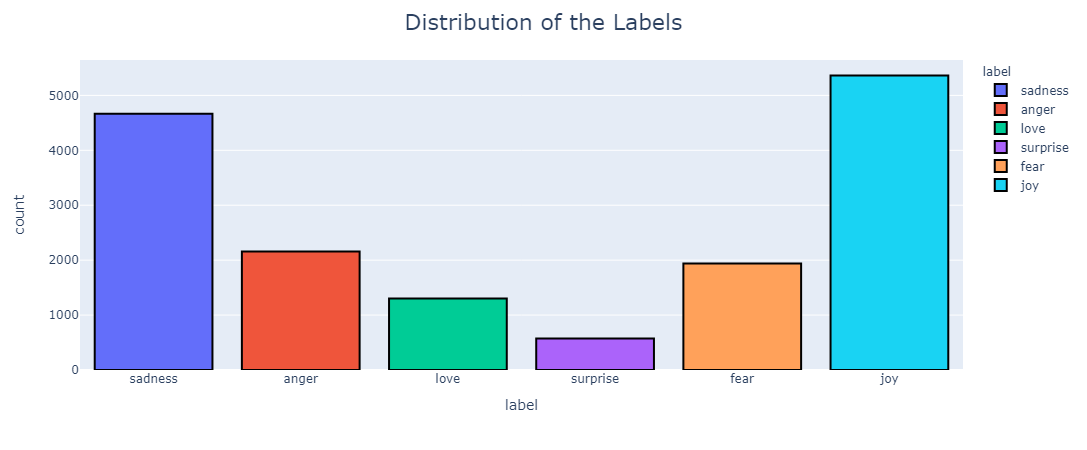

In [11]:
# Label Distribution

fig = px.histogram(train, x='label', color='label')

fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))

fig.update_layout(title_text='Distribution of the Labels',
                  title_x=0.5,
                  title_font=dict(size=22))
fig.show()

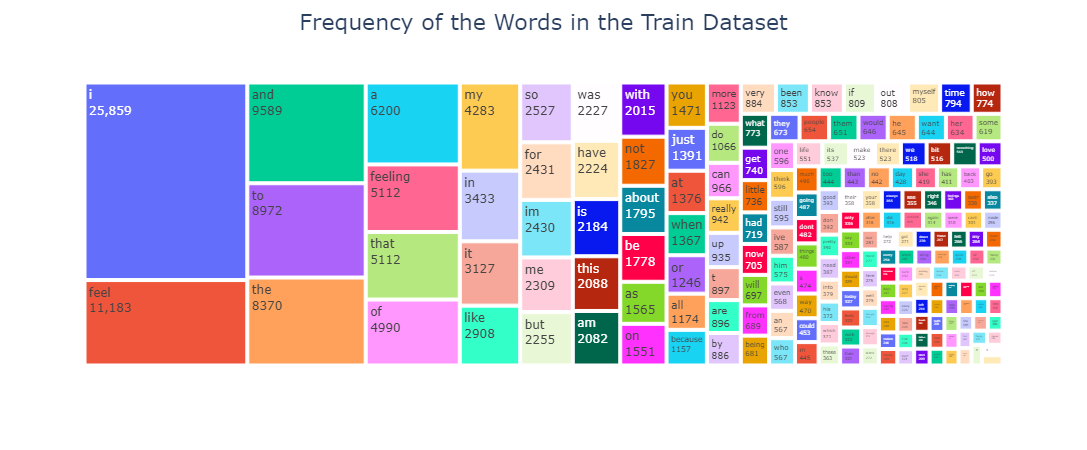

In [12]:
# Word Frequency

FreqOfWords = train['text'].str.split(expand=True).stack().value_counts()
FreqOfWords_top200 = FreqOfWords[:200]

fig = px.treemap(FreqOfWords_top200, path=[FreqOfWords_top200.index], values=0)

fig.update_layout(title_text='Frequency of the Words in the Train Dataset',
                  title_x=0.5,
                  title_font=dict(size=22))

fig.update_traces(textinfo="label+value")
fig.show()

#### Tokenize with NLTK to remove most common stop words as seen above

In [17]:
# Tokenize text inputs for preprocessing
def tokenization(inputs):
    return word_tokenize(inputs)


train['text_tokenized'] = train['text'].apply(tokenization)
validation['text_tokenized'] = validation['text'].apply(tokenization)

In [18]:
train.head()

,label,text,length_of_text,text_tokenized,text_stop
0,sadness,i didnt feel humiliated,4,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]"
1,sadness,i can go from feeling so hopeless to so damned...,21,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun..."
2,anger,im grabbing a minute to post i feel greedy wrong,10,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]"
3,love,i am ever feeling nostalgic about the fireplac...,18,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st..."
4,anger,i am feeling grouchy,4,"[i, am, feeling, grouchy]","[feeling, grouchy]"


In [19]:
# Remove Common Stopwords

stop_words = set(stopwords.words('english'))

def stopwords_remove(inputs):
    return [item for item in inputs if item not in stop_words]

train['text_stop'] = train['text_tokenized'].apply(stopwords_remove)
validation['text_stop'] = validation['text_tokenized'].apply(stopwords_remove)

In [20]:
train.head()

,label,text,length_of_text,text_tokenized,text_stop
0,sadness,i didnt feel humiliated,4,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]"
1,sadness,i can go from feeling so hopeless to so damned...,21,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun..."
2,anger,im grabbing a minute to post i feel greedy wrong,10,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]"
3,love,i am ever feeling nostalgic about the fireplac...,18,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st..."
4,anger,i am feeling grouchy,4,"[i, am, feeling, grouchy]","[feeling, grouchy]"


In [21]:
# lemmatization of word inflections

lemmatizer = WordNetLemmatizer()

def lemmatization(inputs):
    return [lemmatizer.lemmatize(word=x, pos='v') for x in inputs]

train['text_lemmatized'] = train['text_stop'].apply(lemmatization)
validation['text_lemmatized'] = validation['text_stop'].apply(lemmatization)

In [22]:
train.head()

,label,text,length_of_text,text_tokenized,text_stop,text_lemmatized
0,sadness,i didnt feel humiliated,4,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]","[didnt, feel, humiliate]"
1,sadness,i can go from feeling so hopeless to so damned...,21,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun...","[go, feel, hopeless, damn, hopeful, around, so..."
2,anger,im grabbing a minute to post i feel greedy wrong,10,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]","[im, grab, minute, post, feel, greedy, wrong]"
3,love,i am ever feeling nostalgic about the fireplac...,18,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st...","[ever, feel, nostalgic, fireplace, know, still..."
4,anger,i am feeling grouchy,4,"[i, am, feeling, grouchy]","[feeling, grouchy]","[feel, grouchy]"


In [23]:
# Rejoin cleaned tokens into sentences

train['text_cleaned'] = train['text_lemmatized'].str.join(' ')
validation['text_cleaned'] = validation['text_lemmatized'].str.join(' ')

In [24]:
# Final Dataset format
train.head() 

,label,text,length_of_text,text_tokenized,text_stop,text_lemmatized,text_cleaned
0,sadness,i didnt feel humiliated,4,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]","[didnt, feel, humiliate]",didnt feel humiliate
1,sadness,i can go from feeling so hopeless to so damned...,21,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun...","[go, feel, hopeless, damn, hopeful, around, so...",go feel hopeless damn hopeful around someone c...
2,anger,im grabbing a minute to post i feel greedy wrong,10,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]","[im, grab, minute, post, feel, greedy, wrong]",im grab minute post feel greedy wrong
3,love,i am ever feeling nostalgic about the fireplac...,18,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st...","[ever, feel, nostalgic, fireplace, know, still...",ever feel nostalgic fireplace know still property
4,anger,i am feeling grouchy,4,"[i, am, feeling, grouchy]","[feeling, grouchy]","[feel, grouchy]",feel grouchy
